Epoch 0 Cost 0.2509776554299935
Epoch 1 Cost 0.25026992145835486
Epoch 2 Cost 0.24873173731426193
Epoch 3 Cost 0.24784218958257415
Epoch 4 Cost 0.2455523560119886
Epoch 5 Cost 0.2448813899295367
Epoch 6 Cost 0.2434644273740976
Epoch 7 Cost 0.24180784677075312
Epoch 8 Cost 0.2410897971189882
Epoch 9 Cost 0.2394221141661435
Epoch 10 Cost 0.24038826161903737
Epoch 11 Cost 0.23562834625161322
Epoch 12 Cost 0.23381429887622251
Epoch 13 Cost 0.2327179103156816
Epoch 14 Cost 0.2301804282234884
Epoch 15 Cost 0.2272597959790654
Epoch 16 Cost 0.22511611884606397
Epoch 17 Cost 0.22037342878141697
Epoch 18 Cost 0.2167673006231173
Epoch 19 Cost 0.20727876488330266
Epoch 20 Cost 0.19757897432844768
Epoch 21 Cost 0.19204274930111348
Epoch 22 Cost 0.16502110062006556
Epoch 23 Cost 0.13459752451750645
Epoch 24 Cost 0.13268985482876325
Epoch 25 Cost 0.07533638601064377
Epoch 26 Cost 0.03723545732793303
Epoch 27 Cost 0.0017656051737926868
Epoch 28 Cost 0.03482299468634145
Epoch 29 Cost 0.0367102358943910

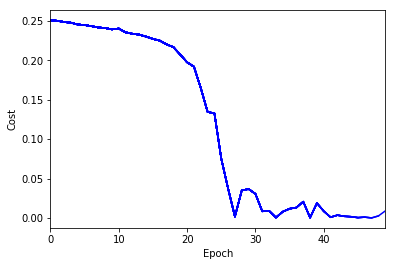

In [88]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import torch.nn.functional as F
from torch.nn.utils import weight_norm
import matplotlib.pyplot as plt

df = pd.read_csv("~/Downloads/BTCUSDT_1M_500000.csv")

rdf = np.array(df[['open']])
dfr = np.zeros(500000)
for i in range(499999):
    dfr[i] = np.log(rdf[i+1]/rdf[i])

data = np.zeros(1387)
for i in np.arange(1387):
    data[i] = dfr[360*i]
data1 = torch.tensor(data)

x_train = data1[:1248]
x_test = data1[1248:]

def batch():
    k = np.random.randint(0, len(x_train)-1100)
    return x_train[k:k+1100], x_train[k+1101]

def testbatch():
    k = np.random.randint(0, 10)
    return x_test[k:k+127], x_test[k+128]

class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, dropout):
        super(TCN, self).__init__()
        self.tcn = TemporalConvNet(input_size, num_channels, kernel_size=kernel_size, dropout=dropout)
        self.linear = nn.Linear(num_channels[-1], output_size)
        self.init_weights()

    def init_weights(self):
        self.linear.weight.data.normal_(0, 0.01)

    def forward(self, x):
        y1 = self.tcn(x)
        return self.linear(y1[:, :, -1])

input_channels = 1100
no_epochs = 50

channel_sizes = [1100,100,50,3]
kernel_size = 2
dropout = 0.2
model = TCN(input_channels, 1, channel_sizes, kernel_size=kernel_size, dropout=dropout)
model=model.double()

lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

costs=[]
plt.ion()
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('Epoch')
ax.set_ylabel('Cost')
ax.set_xlim(0,no_epochs-1)


def train(no_epochs):
    for epoch in range(no_epochs):
        x, y = batch()
        y = y.view(1,-1).double()
        output = model.forward(x.unsqueeze(1).unsqueeze(0))
        loss = F.mse_loss(output, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        costs.append(loss.item())
        print('Epoch',epoch,'Cost',loss.item())
        ax.plot(costs, 'b')
        fig.canvas.draw()
    plt.show()
train(no_epochs)


In [102]:
correct = 0
testinput_channels = 127
testchannel_sizes = [127,100,50,3]
kernel_size = 2
dropout = 0.2
testmodel = TCN(testinput_channels, 1, testchannel_sizes, kernel_size=kernel_size, dropout=dropout)
testmodel=testmodel.double()
def evaluate():
    global correct
    model.eval()
    for i in range(10):
        xtest, ytest = testbatch()
        ytest = ytest.view(1,-1).double()
        output = testmodel.forward(xtest.unsqueeze(1).unsqueeze(0))
        testloss = F.mse_loss(output,ytest)
        correct += testloss
    return correct/10

acc = evaluate()
print('Test accuracy: ', float(acc))



Test accuracy:  0.1555146553672902
